In [1]:
 !pip install -q torch torchvision matplotlib opencv-python-headless scikit-image scikit-learn PyWavelet Pillow tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT_IMAGES = '/content/drive/MyDrive/project_codes/models_new/JPEGImages'

In [4]:
# Imports
import os
import cv2
import numpy as np
import pywt
from scipy.fftpack import dct, idct
import hashlib
import hmac
import math
import warnings
import matplotlib.pyplot as plt
from skimage import data, img_as_float, io, color
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.decomposition import PCA
import torch
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm


In [5]:
# Utility helpers

def pil_to_cv2(img_pil):
    arr = np.array(img_pil)
    if arr.ndim == 2:
        return arr
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)


def cv2_to_pil(img_cv2):
    if img_cv2.ndim == 2:
        from PIL import Image
        return Image.fromarray(img_cv2)
    from PIL import Image
    return Image.fromarray(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))


def to_y_channel(rgb_img):
    # rgb_img in range [0,1] or [0,255]
    img = rgb_img.copy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    Y = ycbcr[:, :, 0].astype(np.float32) / 255.0
    return Y


In [6]:
# Feature extractor (VGG conv3_3 pooled)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vgg = models.vgg16(pretrained=True).features.to(device).eval()
# We'll extract activation after layer 10 (conv3_3-ish)
layer_idx = 10

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

from torch import nn

class VGGHook():
    def __init__(self, model, layer_idx):
        self.model = model
        self.layer_idx = layer_idx
        self.activation = None
        self.handle = self.model[self.layer_idx].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.activation = output.detach()
    def close(self):
        self.handle.remove()

hook = VGGHook(vgg, layer_idx)


def extract_vgg_descriptor(rgb_img, pca=None):
    # rgb_img: HxWx3 uint8 RGB
    img_t = transform(rgb_img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = vgg(img_t)
        feat = hook.activation  # shape [1, C, H, W]
        pooled = torch.nn.functional.adaptive_avg_pool2d(feat, (1,1)).squeeze().cpu().numpy()
    if pca is not None:
        return pca.transform(pooled.reshape(1,-1)).ravel()
    return pooled.ravel()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# PCA helper (to reduce feature dimension)

def fit_pca_on_sample_images(sample_images, n_comp=128):
    feats = []
    for img in sample_images:
        f = extract_vgg_descriptor(img)
        feats.append(f)
    feats = np.stack(feats, axis=0)
    pca = PCA(n_components=n_comp)
    pca.fit(feats)
    return pca


In [8]:
# HMAC digest

def compute_hmac_digest(feature_vec, key=b'secret_key', digest_bits=128):
    # feature_vec: 1D float array
    # We quantize the feature vector to bytes deterministically
    feat_bytes = feature_vec.astype(np.float32).tobytes()
    mac = hmac.new(key, feat_bytes, hashlib.sha256).digest()
    # convert to bitstring and truncate
    bitstr = ''.join(f'{b:08b}' for b in mac)
    return bitstr[:digest_bits]


In [9]:
# DWT + DCT + SVD embedding helpers

def dwt2_channel(channel):
    coeffs = pywt.dwt2(channel, 'haar')
    LL, (LH, HL, HH) = coeffs
    return coeffs


def idwt2_channel(coeffs):
    return pywt.idwt2(coeffs, 'haar')


def block_dct(block):
    # block: float32
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def block_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')


def svd_modify_and_reconstruct(A, Wbits, alpha=0.01):
    # A: 2D array (DCT coefficients). We'll perturb singular values according to bits
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    S_mod = S.copy()
    # embed bits into the largest k singular values' LSB by small additive offset
    k = min(len(Wbits), len(S_mod))
    for i in range(k):
        bit = int(Wbits[i])
        # map bit 0->-1, 1->+1 small change relative to singular value
        S_mod[i] = S_mod[i] + alpha * (1 if bit==1 else -1) * (np.mean(S) + 1e-8)
    A_mod = U @ np.diag(S_mod) @ Vt
    return A_mod

In [10]:
# SIFT patching helpers

def get_sift_keypoints(rgb_img, max_kp=64):
    # expects uint8 RGB
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kps = sift.detect(gray, None)
    kps = sorted(kps, key=lambda x: -x.response)[:max_kp]
    return kps


def extract_patch(img, kp, patch_size=64):
    "Return a padded patch plus the valid region coordinates and shape."
    x, y = int(round(kp.pt[0])), int(round(kp.pt[1]))
    half = patch_size // 2
    h, w = img.shape[:2]

    x1 = max(0, x - half)
    x2 = min(w, x + half)
    y1 = max(0, y - half)
    y2 = min(h, y + half)

    patch = img[y1:y2, x1:x2]
    valid_h, valid_w = patch.shape[:2]

    if valid_h == 0 or valid_w == 0:
        # Degenerate keypoint; skip by returning a zero patch
        padded = np.zeros((patch_size, patch_size, img.shape[2] if img.ndim == 3 else 1), dtype=img.dtype)
        return padded, (x1, y1, x1, y1), (0, 0)

    if valid_h != patch_size or valid_w != patch_size:
        pad_bottom = patch_size - valid_h
        pad_right = patch_size - valid_w
        patch = cv2.copyMakeBorder(
            patch,
            top=0,
            bottom=pad_bottom,
            left=0,
            right=pad_right,
            borderType=cv2.BORDER_REPLICATE
        )

    bbox = (x1, y1, x1 + valid_w, y1 + valid_h)
    return patch, bbox, (valid_h, valid_w)

In [11]:
# Embedding routine across N SIFT patches

def embed_digest_in_image(rgb_img, digest_bits, N_patches=8, patch_size=64, alpha=0.02, key=b'secret'):
    # rgb_img: uint8 RGB
    kp_list = get_sift_keypoints(rgb_img, max_kp=N_patches*4)
    chosen = kp_list[:N_patches]
    if len(chosen) == 0:
        raise ValueError("No SIFT keypoints available for embedding. Try increasing image texture or patch count.")
    Y = to_y_channel(rgb_img)  # float [0,1]
    Y_out = Y.copy()
    embed_locations = []
    total_bits = max(1, len(digest_bits))
    actual_patches = len(chosen)
    max_bits_per_patch = max(1, patch_size // 2)
    capacity = actual_patches * max_bits_per_patch
    if capacity < total_bits:
        raise ValueError(f"Insufficient embedding capacity: need {total_bits} bits but only {capacity} bits available. Increase patch count or reduce payload.")
    bits_per_patch = max(1, math.ceil(total_bits / actual_patches))
    bits_per_patch = min(bits_per_patch, max_bits_per_patch)
    padded_bits = digest_bits.ljust(bits_per_patch * actual_patches, '0')

    for i, kp in enumerate(chosen):
        patch, (x1, y1, x2, y2), (valid_h, valid_w) = extract_patch(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR), kp, patch_size)
        if valid_h == 0 or valid_w == 0:
            continue
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        Yp = to_y_channel(patch_rgb)
        LL, (LH, HL, HH) = dwt2_channel(Yp)
        dct_LL = block_dct(LL)
        start = i * bits_per_patch
        bits = padded_bits[start:start + bits_per_patch]
        dct_mod = svd_modify_and_reconstruct(dct_LL, bits, alpha=alpha)
        LL_mod = block_idct(dct_mod)
        Yp_mod = idwt2_channel((LL_mod, (LH, HL, HH)))

        hpatch, wpatch = Yp_mod.shape
        target_h = min(valid_h, hpatch)
        target_w = min(valid_w, wpatch)
        if target_h <= 0 or target_w <= 0:
            continue
        Y_out[y1:y1 + target_h, x1:x1 + target_w] = Yp_mod[:target_h, :target_w]
        embed_locations.append((x1, y1, x1 + target_w, y1 + target_h))

    img = (rgb_img.copy()).astype(np.uint8)
    ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb).astype(np.float32)
    ycbcr[:, :, 0] = np.clip(Y_out * 255.0, 0, 255)
    out_rgb = cv2.cvtColor(ycbcr.astype(np.uint8), cv2.COLOR_YCrCb2RGB)
    return out_rgb, embed_locations, bits_per_patch


In [16]:
# Extraction routine from patches

def extract_digest_from_image(rgb_img, N_patches=8, patch_size=64, bits_per_patch=16, alpha=0.02):
    kp_list = get_sift_keypoints(rgb_img, max_kp=N_patches * 4)
    chosen = kp_list[:N_patches]
    extracted_bits = []
    for kp in chosen:
        patch, (x1, y1, x2, y2), (valid_h, valid_w) = extract_patch(
            cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR), kp, patch_size
        )
        if valid_h == 0 or valid_w == 0:
            continue
        Yp = to_y_channel(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        LL, (LH, HL, HH) = dwt2_channel(Yp)
        dct_LL = block_dct(LL)
        U, S, Vt = np.linalg.svd(dct_LL, full_matrices=False)
        med = np.median(S)
        k = min(bits_per_patch, len(S))
        patch_bits = ''.join('1' if (s - med) > 0 else '0' for s in S[:k])
        extracted_bits.append(patch_bits)
    return ''.join(extracted_bits)

In [17]:
# Attack simulator (benign + malicious)

def attack_jpeg(img, quality=75):
    # img: uint8 RGB
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    is_success, encimg = cv2.imencode('.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR), encode_param)
    decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
    return cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)


def attack_resize(img, scale=0.8):
    h,w = img.shape[:2]
    newh,neww = max(1,int(h*scale)), max(1,int(w*scale))
    small = cv2.resize(img, (neww,newh), interpolation=cv2.INTER_AREA)
    back = cv2.resize(small, (w,h), interpolation=cv2.INTER_LINEAR)
    return back


def attack_blur(img, ksize=3):
    return cv2.GaussianBlur(img, (ksize,ksize), 0)


def attack_rotate(img, angle=10):
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w,h), borderMode=cv2.BORDER_REFLECT)


def attack_crop(img, crop_ratio=0.85):
    h, w = img.shape[:2]
    ch = max(1, int(h * crop_ratio))
    cw = max(1, int(w * crop_ratio))
    y1 = max(0, (h - ch) // 2)
    x1 = max(0, (w - cw) // 2)
    cropped = img[y1:y1+ch, x1:x1+cw]
    return cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)


def attack_combined_heavy(img):
    out = attack_rotate(img, angle=20)
    out = attack_crop(out, crop_ratio=0.85)
    out = attack_jpeg(out, quality=40)
    out = attack_blur(out, ksize=5)
    return out

# compound

def compound_benign(img):
    out = attack_resize(img, scale=0.9)
    out = attack_jpeg(out, quality=85)
    out = attack_blur(out, ksize=3)
    return out

# malicious example: splice patch from another image

def malicious_splice(img, donor):
    h,w = img.shape[:2]
    dh,dw = donor.shape[:2]
    # take central crop from donor and paste to center of img
    ch, cw = dh//2, dw//2
    patch = donor[ch-50:ch+50, cw-50:cw+50]
    out = img.copy()
    H,W = out.shape[:2]
    x1,y1 = W//2 - patch.shape[1]//2, H//2 - patch.shape[0]//2
    out[y1:y1+patch.shape[0], x1:x1+patch.shape[1]] = patch
    return out


In [18]:
# Decision logic

def hamming_distance(s1, s2):
    # equal-length bitstrings
    return sum(c1!=c2 for c1,c2 in zip(s1,s2))


def verify_semi_fragile(received_rgb, original_rgb, key=b'secret_key', N_patches=8, digest_bits=128, bits_per_patch=16, T_accept=12, T_reject=30):
    # recompute digest from received (for semi-fragile we want to recompute from received image features)
    # but using original features would be used for owner-side. Here we simulate both.
    # For user's verification: owner stores digest(original) and compares
    # For simplicity, owner digest computed from original
    pca = None
    orig_feat = extract_vgg_descriptor(original_rgb)
    orig_digest = compute_hmac_digest(orig_feat, key=key, digest_bits=digest_bits)

    # extract bits from received
    extracted = extract_digest_from_image(received_rgb, N_patches=N_patches, patch_size=64, bits_per_patch=bits_per_patch)
    # if extracted shorter than digest, pad/truncate
    extracted = extracted[:digest_bits]
    if len(extracted) < digest_bits:
        extracted = extracted.ljust(digest_bits, '0')

    # recompute digest from received features
    rec_feat = extract_vgg_descriptor(received_rgb)
    rec_digest = compute_hmac_digest(rec_feat, key=key, digest_bits=digest_bits)

    # compare
    ham1 = hamming_distance(extracted, orig_digest)
    ham2 = hamming_distance(extracted, rec_digest)
    # Decision: if extracted close to recomputed -> likely benign; if far from recomputed and far from original -> tampered
    if ham2 <= T_accept:
        return 'PASS', ham1, ham2, extracted, orig_digest, rec_digest
    elif ham2 > T_reject:
        return 'TAMPER', ham1, ham2, extracted, orig_digest, rec_digest
    else:
        return 'UNCERTAIN', ham1, ham2, extracted, orig_digest, rec_digest


Digest bits length: 128
Benign result: TAMPER hamming to orig,rec: 60 72
Malicious result: TAMPER hamming to orig,rec: 60 62


(np.float64(-0.5), np.float64(450.5), np.float64(299.5), np.float64(-0.5))

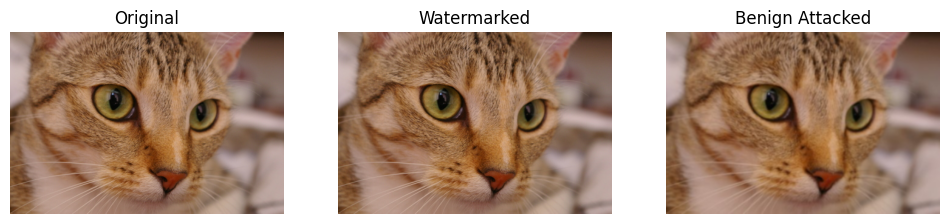

In [19]:
# Quick demo run (example images)
from skimage import data
img = img_as_float(data.chelsea())  # cat image
img_uint8 = (img*255).astype(np.uint8)
# make a donor image
donor = img_as_float(data.astronaut())
donor_uint8 = (donor*255).astype(np.uint8)

# Fit PCA on small sample (optional) - omitted to keep runtime low

# compute feature and digest
feat = extract_vgg_descriptor(img_uint8)
digest = compute_hmac_digest(feat, key=b'my_secret_key', digest_bits=128)
print('Digest bits length:', len(digest))

# embed
watermarked, locs, bits_per_patch = embed_digest_in_image(img_uint8, digest, N_patches=8, patch_size=64, alpha=0.02)

# attack benign
attacked_benign = compound_benign(watermarked)
# attack malicious
attacked_malicious = malicious_splice(watermarked, donor_uint8)

# verify
res_benign = verify_semi_fragile(attacked_benign, img_uint8, key=b'my_secret_key', bits_per_patch=bits_per_patch)
res_mal = verify_semi_fragile(attacked_malicious, img_uint8, key=b'my_secret_key', bits_per_patch=bits_per_patch)
print('Benign result:', res_benign[0], 'hamming to orig,rec:', res_benign[1], res_benign[2])
print('Malicious result:', res_mal[0], 'hamming to orig,rec:', res_mal[1], res_mal[2])

# show images
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img_uint8); plt.axis('off')
plt.subplot(1,3,2); plt.title('Watermarked'); plt.imshow(watermarked); plt.axis('off')
plt.subplot(1,3,3); plt.title('Benign Attacked'); plt.imshow(attacked_benign); plt.axis('off')


In [20]:
# Additional imports for training
import random
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

In [21]:
# Simple Dataset wrapper: use a directory of images (place images in ./images_train)
class SimpleImageFolder(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.paths = list(Path(root_dir).glob('**/*.jpg')) \
           + list(Path(root_dir).glob('**/*.JPG')) \
           + list(Path(root_dir).glob('**/*.jpeg')) \
           + list(Path(root_dir).glob('**/*.png')) \
           + list(Path(root_dir).glob('**/*.PNG'))
        self.t = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = str(self.paths[idx])
        img = io.imread(p)
        if img.ndim==2:
            img = np.stack([img,img,img],axis=-1)
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img = img / 255.0
        img_t = torch.from_numpy(img).permute(2,0,1)
        img_t = F.interpolate(img_t.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
        return img_t


In [22]:
# Small U-Net style encoder (produces residual) and decoder
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden=64, payload_len=64):
        super().__init__()
        self.hidden = hidden
        self.payload_len = payload_len
        self.payload_embed = nn.Sequential(
            nn.Linear(payload_len, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.down1 = nn.Sequential(nn.Conv2d(in_channels + hidden, hidden, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(hidden, hidden, 3, padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(hidden, hidden*2, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(hidden*2, hidden*2, 3, padding=1), nn.ReLU())
        self.up1 = nn.Sequential(nn.ConvTranspose2d(hidden*2, hidden, 2, stride=2), nn.ReLU())
        self.out_conv = nn.Conv2d(hidden, in_channels, 1)
    def forward(self, x, payload_bits):
        if payload_bits is None:
            payload_bits = torch.zeros(x.size(0), self.payload_len, device=x.device, dtype=x.dtype)
        payload_feat = self.payload_embed(payload_bits)
        payload_feat = payload_feat.view(payload_feat.size(0), self.hidden, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, payload_feat], dim=1)
        d1 = self.down1(x_in)
        p = self.pool(d1)
        d2 = self.down2(p)
        u = self.up1(d2)
        # skip connection
        r = u + d1
        res = torch.tanh(self.out_conv(r)) * 0.1  # small residual scale
        return res

class Decoder(nn.Module):
    def __init__(self, in_channels=3, payload_len=64, hidden=64):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, hidden, 3, padding=1), nn.ReLU(),
                                  nn.AdaptiveAvgPool2d((16,16)))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(hidden*16*16, 512), nn.ReLU(), nn.Linear(512, payload_len))
    def forward(self, x):
        f = self.conv(x)
        out = self.fc(f)
        return out

In [23]:
# Differentiable attack pipeline (torch tensors)
class DifferentiableAttack(nn.Module):
    def __init__(self, p_jpeg=0.5):
        super().__init__()
        self.p_jpeg = p_jpeg
    def forward(self, imgs):
        # imgs: [B,3,H,W] in [0,1]
        x = imgs
        # random resize + rescale
        if random.random() < 0.9:
            scales = torch.empty(x.size(0)).uniform_(0.8,1.0).tolist()
            out = torch.zeros_like(x)
            for i,s in enumerate(scales):
                h,w = x.shape[2], x.shape[3]
                nh, nw = max(1,int(h*s)), max(1,int(w*s))
                small = F.interpolate(x[i:i+1], size=(nh,nw), mode='bilinear', align_corners=False)
                back = F.interpolate(small, size=(h,w), mode='bilinear', align_corners=False)
                out[i:i+1] = back
            x = out
        # random rotation small
        if random.random() < 0.5:
            angles = torch.empty(x.size(0)).uniform_(-10,10).tolist()
            grid_list = []
            theta_batch = []
            for ang in angles:
                theta = torch.tensor([[np.cos(np.deg2rad(ang)), -np.sin(np.deg2rad(ang)), 0.0],
                                       [np.sin(np.deg2rad(ang)),  np.cos(np.deg2rad(ang)), 0.0]], dtype=torch.float)
                theta_batch.append(theta.unsqueeze(0))
            theta_batch = torch.cat(theta_batch, dim=0).to(x.device)
            grid = F.affine_grid(theta_batch, x.size(), align_corners=False)
            x = F.grid_sample(x, grid, padding_mode='border', align_corners=False)
        # gaussian blur approximated by depthwise conv
        if random.random() < 0.7:
            k = random.choice([1,3,5])
            if k>1:
                kernel = torch.tensor(cv2.getGaussianKernel(k, k/3).astype(np.float32))
                kernel2 = kernel @ kernel.T
                kernel2 = kernel2 / kernel2.sum()
                k_t = kernel2.unsqueeze(0).unsqueeze(0).to(x.device)
                pad = k//2
                out = F.pad(x, (pad,pad,pad,pad), mode='reflect')
                # conv per channel
                out_c = []
                for c in range(3):
                    kc = k_t
                    out_c.append(F.conv2d(out[:,c:c+1,:,:], kc, padding=0))
                x = torch.cat(out_c, dim=1)
        # additive noise
        if random.random() < 0.9:
            noise = torch.randn_like(x) * 0.005
            x = torch.clamp(x + noise, 0, 1)
        # non-diff JPEG: apply with probability p_jpeg using PIL round-trip on CPU
        if random.random() < self.p_jpeg:
            x_cpu = (x.detach().cpu().clamp(0,1).permute(0,2,3,1).numpy()*255).astype(np.uint8)
            out_cpu = []
            for i in range(x_cpu.shape[0]):
                bgr = cv2.cvtColor(x_cpu[i], cv2.COLOR_RGB2BGR)
                q = random.randint(60,95)
                _, enc = cv2.imencode('.jpg', bgr, [int(cv2.IMWRITE_JPEG_QUALITY), q])
                dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)
                dec_rgb = cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)
                out_cpu.append(dec_rgb.astype(np.float32)/255.0)
            x = torch.from_numpy(np.stack(out_cpu, axis=0)).permute(0,3,1,2).to(x.device)
        return x

In [24]:
vgg_loss_model = models.vgg16(pretrained=True).features[:16].to(device).eval()
for p in vgg_loss_model.parameters():
    p.requires_grad = False

def perceptual_loss(x, y):
    # expects [B,3,H,W] in [0,1], convert to vgg input range
    def prep(z):
        z_clamped = torch.clamp(z,0,1)
        # normalize
        mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1).to(z.device)
        std = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1).to(z.device)
        return (z_clamped - mean)/std
    xf = prep(x)
    yf = prep(y)
    f1 = vgg_loss_model(xf)
    f2 = vgg_loss_model(yf)
    return F.mse_loss(f1, f2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Training loop

def train_residual_encoder(root_images='/content/drive/MyDrive/project_codes/models_new/JPEGImages', epochs=10, batch_size=8, payload_len=64, lr=1e-4, save_every=1):
    dataset = SimpleImageFolder(root_images)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    enc = Encoder(payload_len=payload_len).to(device)
    dec = Decoder(payload_len=payload_len).to(device)
    attack = DifferentiableAttack().to(device)
    optim = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=lr)

    for epoch in range(epochs):
        enc.train(); dec.train()
        epoch_loss = 0.0
        start = time.time()
        for imgs in loader:
            imgs = imgs.to(device).float()
            B = imgs.size(0)
            # random payload per image
            payload = torch.randint(0,2,(B,payload_len), device=device).float()
            residual = enc(imgs, payload)
            watermarked = torch.clamp(imgs + residual, 0.0, 1.0)
            # Attack
            attacked = attack(watermarked)
            # Decoder attempts to recover payload from attacked image
            logits = dec(attacked)
            bce = F.binary_cross_entropy_with_logits(logits, payload)
            mse = F.mse_loss(watermarked, imgs)
            perc = perceptual_loss(watermarked, imgs)
            loss = bce + 0.1*mse + 0.5*perc
            optim.zero_grad(); loss.backward(); optim.step()
            epoch_loss += loss.item()
        dur = time.time() - start
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(loader):.4f} - time: {dur:.1f}s")
        # save
        if (epoch+1) % save_every == 0:
            torch.save({'enc':enc.state_dict(), 'dec':dec.state_dict()}, f'residual_checkpoint_epoch{epoch+1}.pt')
    return enc, dec


In [26]:
!pip install -q reedsolo


In [27]:
import reedsolo

In [28]:
# Bit/byte helpers

def bits_to_bytes(bitstr: str) -> bytes:
    # pad to byte boundary
    pad = (-len(bitstr)) % 8
    bitstr_padded = bitstr + ('0'*pad)
    b = bytes(int(bitstr_padded[i:i+8], 2) for i in range(0, len(bitstr_padded), 8))
    return b

def bytes_to_bits(b: bytes, nbits: int=None) -> str:
    s = ''.join(f'{byte:08b}' for byte in b)
    if nbits is None:
        return s
    return s[:nbits]

In [29]:
# Reed-Solomon wrappers
def rs_encode_bits(bitstr: str, nsym: int=32) -> str:
    """
    Encode a bitstring with Reed-Solomon. Returns encoded bits (as string).
    nsym: number of parity bytes to use (higher -> stronger ECC but longer codeword).
    """
    b = bits_to_bytes(bitstr)
    rsc = reedsolo.RSCodec(nsym)
    enc = rsc.encode(b)
    return bytes_to_bits(enc)


def rs_decode_bits(encoded_bitstr: str, orig_nbits: int, nsym: int=32):
    """
    Decode a Reed-Solomon encoded bitstring back to original bits.
    Returns (decoded_bitstr, success_flag, errors_corrected)
    """
    try:
        enc_bytes = bits_to_bytes(encoded_bitstr)
        rsc = reedsolo.RSCodec(nsym)
        dec, _, _ = rsc.decode(enc_bytes)
        dec_bits = bytes_to_bits(dec, orig_nbits)
        return dec_bits, True, None
    except Exception as e:
        # decoding failed
        return None, False, str(e)


In [30]:
# Update embedding routine to accept ECC encoded digest

def embed_digest_with_rs(rgb_img, digest_bits, nsym=32, patch_size=64, min_patches=8, **kwargs):
    current_nsym = nsym
    last_error = None
    while current_nsym >= 1:
        enc_bits = rs_encode_bits(digest_bits, nsym=current_nsym)
        max_bits_per_patch = max(1, patch_size // 2)
        required_patches = math.ceil(len(enc_bits) / max_bits_per_patch)
        desired_patches = max(min_patches, required_patches)
        kwargs_local = dict(kwargs)
        N_patches = max(kwargs_local.pop('N_patches', desired_patches), desired_patches)
        try:
            wm_img, locations, bits_per_patch = embed_digest_in_image(
                rgb_img,
                enc_bits,
                N_patches=N_patches,
                patch_size=patch_size,
                **kwargs_local
            )
            return wm_img, locations, bits_per_patch, enc_bits, current_nsym
        except ValueError as e:
            last_error = e
            if current_nsym <= 4:
                break
            reduced_nsym = max(4, current_nsym // 2)
            warnings.warn(
                f"Embedding capacity limited; reducing Reed-Solomon parity bytes from {current_nsym} to {reduced_nsym}.",
                RuntimeWarning
            )
            current_nsym = reduced_nsym
    raise ValueError(f"Failed to embed ECC-protected watermark: {last_error}")


In [38]:
# Per-patch extraction that returns confidence as well

def extract_digest_with_confidence(rgb_img, N_patches=8, patch_size=64, bits_per_patch=16, alpha=0.02):
    kp_list = get_sift_keypoints(rgb_img, max_kp=N_patches * 4)
    chosen = kp_list[:N_patches]
    extracted_bits = []
    confidences = []
    boxes = []
    for kp in chosen:
        patch, (x1, y1, x2, y2), (valid_h, valid_w) = extract_patch(
            cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR), kp, patch_size
        )
        if valid_h == 0 or valid_w == 0:
            continue
        Yp = to_y_channel(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
        LL, (LH, HL, HH) = dwt2_channel(Yp)
        dct_LL = block_dct(LL)
        U, S, Vt = np.linalg.svd(dct_LL, full_matrices=False)
        med = np.median(S)
        k = min(bits_per_patch, len(S))
        patch_bits = ''.join('1' if (s - med) > 0 else '0' for s in S[:k])
        top_mean = float(np.mean(np.abs(S[:k] - med)))
        denom = float(np.mean(np.abs(S)) + 1e-9)
        conf = 1.0 - np.tanh(top_mean / denom)
        extracted_bits.append(patch_bits)
        confidences.append(conf)
        boxes.append((x1, y1, x2, y2))
    return extracted_bits, confidences, boxes

In [39]:
def weighted_majority_aggregate(extracted_bits_list, confidences, expected_len=None):
    """
    extracted_bits_list: list of strings (per-patch bitstrings, may be shorter)
    confidences: list of floats same length
    expected_len: expected total length of final bitstring (if None, computed)
    returns: aggregated_bitstring, avg_confidence
    """
    if len(extracted_bits_list)==0:
        return '', 0.0
    # first, ensure all bitstrings are padded to same length
    maxlen = max(len(s) for s in extracted_bits_list)
    if expected_len is None:
        expected_len = maxlen
    votes = np.zeros((expected_len, 2), dtype=float)  # counts for 0 and 1
    for s,conf in zip(extracted_bits_list, confidences):
        s_p = s.ljust(expected_len, '0')[:expected_len]
        for i,ch in enumerate(s_p):
            votes[i, int(ch)] += conf
    final_bits = ''.join('1' if votes[i,1] >= votes[i,0] else '0' for i in range(expected_len))
    avg_conf = float(np.mean(confidences))
    return final_bits, avg_conf

In [40]:
# RS-aware extraction wrapper: aggregate patches -> RS decode -> return decoded bits and status

def extract_and_decode_rs(rgb_img, orig_nbits=128, N_patches=8, bits_per_patch=16, nsym=32, encoded_bits_len=None):
    extracted_list, confs, boxes = extract_digest_with_confidence(rgb_img, N_patches=N_patches, patch_size=64, bits_per_patch=bits_per_patch)
    expected_len = encoded_bits_len if encoded_bits_len is not None else orig_nbits + nsym*8
    agg_bits, avg_conf = weighted_majority_aggregate(extracted_list, confs, expected_len=expected_len)
    trimmed_bits = agg_bits[:expected_len]
    decoded, ok, info = rs_decode_bits(trimmed_bits, orig_nbits, nsym=nsym)
    return decoded, ok, info, avg_conf, boxes, confs

In [41]:
# Combine fragile (semi-fragile digest) and robust (ownership watermark) signals
# For demonstration we provide a placeholder robust verification function. In your pipeline,
# replace `robust_verify()` with your actual robust watermark verification routine.

def robust_verify_placeholder(received_img):
    """
    Placeholder returning (owner_id_match:bool, confidence:float).
    Replace with your DWT+DCT+SVD-based robust verification that returns a boolean and a confidence score.
    """
    # Here we simulate: assume robust watermark survives benign attacks, fails for heavy tamper
    # In practice, you should run your robust extraction and compare payload/ECC.
    return True, 0.85


def fuse_decisions(fr_result, fr_conf, robust_ok, robust_conf, thresholds=dict(pass_conf=0.6, tamper_conf=0.3)):
    """
    fr_result: 'PASS' | 'TAMPER' | 'UNCERTAIN'
    fr_conf: float [0,1]
    robust_ok: bool
    robust_conf: float [0,1]

    Fusion rules (simple interpretable logic):
      - If fragile says TAMPER -> return TAMPER (regardless of robust) unless robust strongly confirms owner AND fr_conf very low.
      - If fragile says PASS and robust_ok -> PASS (owner and not tampered).
      - If fragile UNCERTAIN but robust_ok and robust_conf high -> POSSIBLE_PASS.
      - If fragile PASS but robust_ok False -> FLAG_FOR_REVIEW (possible removal of ownership or re-watermarking).
    """
    if fr_result == 'TAMPER':
        if robust_ok and robust_conf > 0.9 and fr_conf < 0.2:
            return 'DISPUTED'  # robust strongly says owner but fragile indicates tamper with low confidence
        return 'TAMPER'
    if fr_result == 'PASS':
        if robust_ok:
            return 'PASS'  # ownership + no tamper
        else:
            return 'PASS_NO_OWNERSHIP'  # image seems unmodified but no robust ownership
    if fr_result == 'UNCERTAIN':
        if robust_ok and robust_conf > 0.7:
            return 'POSSIBLE_PASS'
        elif fr_conf < 0.4 and not robust_ok:
            return 'FLAG_FOR_REVIEW'
        else:
            return 'UNCERTAIN'


In [42]:
# Example combined verification function using the new ECC + voting + fusion

def combined_verification_pipeline(received_rgb, original_rgb, key=b'my_secret_key',
                                   orig_nbits=128, nsym=32, N_patches=8, bits_per_patch=16,
                                   encoded_bits_len=None):
    # Semi-fragile (fragile) path: extract + RS decode
    decoded, ok, info, avg_conf, patch_boxes, patch_confidences = extract_and_decode_rs(received_rgb, orig_nbits=orig_nbits, N_patches=N_patches, bits_per_patch=bits_per_patch, nsym=nsym, encoded_bits_len=encoded_bits_len)
    # compute recomputed digest (owner side)
    orig_feat = extract_vgg_descriptor(original_rgb)
    orig_digest = compute_hmac_digest(orig_feat, key=key, digest_bits=orig_nbits)
    # decision
    if ok and decoded == orig_digest:
        fr_result = 'PASS'
    elif ok and decoded is not None:
        # compare hamming
        ham = hamming_distance(decoded, orig_digest)
        if ham <= 12:
            fr_result = 'PASS'
        elif ham > 30:
            fr_result = 'TAMPER'
        else:
            fr_result = 'UNCERTAIN'
    else:
        fr_result = 'UNCERTAIN'
    # fragile confidence is avg_conf
    fr_conf = avg_conf
    # robust verification (placeholder - replace with actual robust pipeline)
    robust_ok, robust_conf = robust_verify_placeholder(received_rgb)
    fused = fuse_decisions(fr_result, fr_conf, robust_ok, robust_conf)
    return {
        'fragile_result': fr_result,
        'fragile_confidence': fr_conf,
        'robust_ok': robust_ok,
        'robust_confidence': robust_conf,
        'fused_decision': fused,
        'rs_info': info,
        'patch_boxes': patch_boxes,
        'patch_confidences': patch_confidences
    }

In [43]:
# Tamper localization utilities

def compute_structural_heatmap(original_rgb, suspect_rgb, window_size=21, sigma=1.5):
    """Return normalized SSIM-based discrepancy map and similarity score."""
    orig_gray = color.rgb2gray(original_rgb)
    suspect_gray = color.rgb2gray(suspect_rgb)
    score, diff = ssim(
        orig_gray,
        suspect_gray,
        win_size=window_size,
        gaussian_weights=True,
        sigma=sigma,
        use_sample_covariance=False,
        full=True
    )
    heatmap = 1.0 - diff
    heatmap = np.clip(heatmap, 0.0, 1.0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    return heatmap, score


def build_patch_confidence_map(image_shape, patch_boxes, patch_confidences):
    h, w = image_shape[:2]
    accumulator = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.float32)
    for (x1, y1, x2, y2), conf in zip(patch_boxes, patch_confidences):
        accumulator[y1:y2, x1:x2] += conf
        counts[y1:y2, x1:x2] += 1.0
    mask = counts > 0
    accumulator[mask] /= counts[mask]
    return accumulator


def fuse_heatmaps(structural_heatmap, patch_heatmap, weight_structural=0.7):
    patch_rescaled = (patch_heatmap - patch_heatmap.min()) / (patch_heatmap.max() - patch_heatmap.min() + 1e-8)
    fused = np.clip(weight_structural * structural_heatmap + (1 - weight_structural) * patch_rescaled, 0.0, 1.0)
    return fused


def overlay_heatmap(rgb_img, heatmap, cmap='inferno', alpha=0.6):
    import matplotlib.cm as cm
    rgb_norm = rgb_img.astype(np.float32) / 255.0
    colormap = cm.get_cmap(cmap)(heatmap)[..., :3]
    overlay = np.clip(alpha * colormap + (1 - alpha) * rgb_norm, 0.0, 1.0)
    return overlay


def render_tamper_visualization(original_rgb, suspect_rgb, pipeline_result):
    structural_heatmap, ssim_score = compute_structural_heatmap(original_rgb, suspect_rgb)
    patch_boxes = pipeline_result.get('patch_boxes') or []
    patch_confidences = pipeline_result.get('patch_confidences') or []
    if len(patch_boxes) == 0 or len(patch_confidences) == 0:
        fused_heatmap = structural_heatmap
    else:
        patch_map = build_patch_confidence_map(original_rgb.shape, patch_boxes, patch_confidences)
        fused_heatmap = fuse_heatmaps(structural_heatmap, patch_map)
    overlay = overlay_heatmap(suspect_rgb, fused_heatmap)
    return {
        'structural_heatmap': structural_heatmap,
        'fused_heatmap': fused_heatmap,
        'overlay': overlay,
        'ssim_score': ssim_score
    }

In [44]:
# Evaluation harness (run more systematic tests)

def evaluate_on_dataset(images, donor_images, key=b'my_secret_key'):
    stats = {'benign_pass':0, 'benign_total':0, 'mal_pass':0, 'mal_total':0}
    for i,img in enumerate(images):
        img_uint8 = (img*255).astype(np.uint8)
        feat = extract_vgg_descriptor(img_uint8)
        digest = compute_hmac_digest(feat, key=key, digest_bits=128)
        watermarked, locs, bits_per_patch, enc_bits, nsym_used = embed_digest_with_rs(img_uint8, digest, nsym=32)
        # benign
        attacked = compound_benign(watermarked)
        benign_res = combined_verification_pipeline(
            attacked,
            img_uint8,
            key=key,
            orig_nbits=128,
            nsym=nsym_used,
            N_patches=len(locs),
            bits_per_patch=bits_per_patch,
            encoded_bits_len=len(enc_bits)
        )
        stats['benign_total'] += 1
        if benign_res['fused_decision'] in {'PASS', 'PASS_NO_OWNERSHIP', 'POSSIBLE_PASS'}:
            stats['benign_pass'] += 1
        # malicious
        donor = donor_images[i % len(donor_images)]
        mal = malicious_splice(watermarked, (donor*255).astype(np.uint8))
        mal_res = combined_verification_pipeline(
            mal,
            img_uint8,
            key=key,
            orig_nbits=128,
            nsym=nsym_used,
            N_patches=len(locs),
            bits_per_patch=bits_per_patch,
            encoded_bits_len=len(enc_bits)
        )
        stats['mal_total'] += 1
        if mal_res['fused_decision'] in {'TAMPER', 'DISPUTED', 'FLAG_FOR_REVIEW'}:
            stats['mal_pass'] += 1
    return stats

# run small eval using skimage images
images = [img]
donors = [donor]
stats = evaluate_on_dataset(images, donors)
print(stats)


{'benign_pass': 0, 'benign_total': 1, 'mal_pass': 1, 'mal_total': 1}


# Quick example (run after embedding with RS):
# embed with RS
# enc_bits = rs_encode_bits(digest, nsym=32)
# watermarked, _ = embed_digest_in_image(img_uint8, enc_bits, N_patches=8)
# res = combined_verification_pipeline(attacked_benign, img_uint8)
# print(res)

# End of ECC / Voting / Fusion section

# === IMPROVED HYBRID TRAINING & EVALUATION (SUBSET, HIGHER LR, METRICS) ===
# This section replaces/extends the previous training routine with:
# - dataset subsetting (10k train, 2k val, 2k test)
# - hybrid DWT+DCT+SVD embedding retained (embed_digest_in_image)
# - learned residual encoder/decoder (hybrid) with higher LR and scheduler
# - evaluation metrics: Accuracy, Precision, Recall, F1, ROC-AUC, PSNR, SSIM, BER
# - attack suite for realistic testing
# - early stopping and checkpointing


In [45]:
# Additional imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import random
import math

In [46]:
# Utility: create dataset splits (subset 10k train, 2k val, 2k test)
def create_subsets(root_dir, train_n=10000, val_n=2000, test_n=2000, seed=42):
    paths = list(Path(root_dir).glob('**/*.jpg')) + list(Path(root_dir).glob('**/*.png'))
    random.Random(seed).shuffle(paths)
    total_needed = train_n + val_n + test_n
    if len(paths) < total_needed:
        raise ValueError(f"Not enough images in {root_dir} ? found {len(paths)}, need {total_needed}")
    train_paths = paths[:train_n]
    val_paths = paths[train_n:train_n+val_n]
    test_paths = paths[train_n+val_n:train_n+val_n+test_n]
    return train_paths, val_paths, test_paths

class SubsetImageDataset(Dataset):
    def __init__(self, paths, image_size=256):
        self.paths = [str(p) for p in paths]
        self.image_size = image_size
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = io.imread(p)
        if img.ndim==2:
            img = np.stack([img,img,img],axis=-1)
        img = img.astype(np.float32)
        if img.max() > 1.0:
            img = img / 255.0
        # center crop or resize to square
        H,W = img.shape[:2]
        side = min(H,W)
        cy, cx = H//2, W//2
        img_c = img[cy-side//2:cy-side//2+side, cx-side//2:cx-side//2+side]
        img_t = cv2.resize(img_c, (self.image_size, self.image_size), interpolation=cv2.INTER_AREA)
        img_t = torch.from_numpy(img_t).permute(2,0,1).float()
        return img_t


In [47]:
# Hybrid model: encoder produces residual; final watermarked image also runs classical embedding per-batch optionally
class HybridSystem:
    def __init__(self, enc, dec, use_classical_embed=True, digest_bits=128, key=b'my_secret_key', nsym=32):
        self.enc = enc
        self.dec = dec
        self.use_classical = use_classical_embed
        self.digest_bits = digest_bits
        self.key = key
        self.nsym = nsym
        self.last_metadata = []
    def embed_classical_batch(self, imgs_np_batch, return_metadata=False):
        # imgs_np_batch: [B,H,W,3] uint8
        out_list = []
        metadata = []
        for img_np in imgs_np_batch:
            feat = extract_vgg_descriptor(img_np)
            digest = compute_hmac_digest(feat, key=self.key, digest_bits=self.digest_bits)
            try:
                wm, locations, bits_per_patch, enc_bits, nsym_used = embed_digest_with_rs(
                    img_np,
                    digest_bits=digest,
                    nsym=self.nsym,
                    patch_size=64,
                    min_patches=8
                )
                metadata.append({
                    'digest': digest,
                    'encoded_bits': enc_bits,
                    'encoded_len_bits': len(enc_bits),
                    'bits_per_patch': bits_per_patch,
                    'locations': locations,
                    'N_patches': len(locations),
                    'nsym_used': nsym_used,
                    'fallback': False
                })
                out_list.append(wm)
            except ValueError as e:
                warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)
                metadata.append({
                    'digest': digest,
                    'encoded_bits': '',
                    'encoded_len_bits': 0,
                    'bits_per_patch': 0,
                    'locations': [],
                    'N_patches': 0,
                    'nsym_used': 0,
                    'fallback': True
                })
                out_list.append(img_np)
        self.last_metadata = metadata
        wm_array = np.stack(out_list, axis=0)
        if return_metadata:
            return wm_array, metadata
        return wm_array


In [48]:
# Training + evaluation functions

def train_and_evaluate(root_images, gpu_device='cuda', epochs=6, batch_size=16, lr=3e-3, payload_len=64,
                       train_subset=10000, val_subset=2000, test_subset=2000, early_stop_patience=3):
    device = gpu_device if torch.cuda.is_available() else 'cpu'
    print('Using device:', device)
    train_paths, val_paths, test_paths = create_subsets(root_images, train_n=train_subset, val_n=val_subset, test_n=test_subset)
    train_ds = SubsetImageDataset(train_paths)
    val_ds = SubsetImageDataset(val_paths)
    test_ds = SubsetImageDataset(test_paths)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    print('Train samples:', len(train_ds), 'Val:', len(val_ds), 'Test:', len(test_ds))

    enc = Encoder(payload_len=payload_len).to(device)
    dec = Decoder(payload_len=payload_len).to(device)
    attack = DifferentiableAttack().to(device)
    hybrid = HybridSystem(enc, dec, use_classical_embed=True)

    params = list(enc.parameters()) + list(dec.parameters())
    optim = torch.optim.Adam(params, lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=2)

    best_val = 1e9
    no_improve = 0
    history = {'train_loss':[], 'val_loss':[], 'val_bitacc':[], 'val_precision':[], 'val_recall':[], 'val_f1':[]}

    for epoch in range(epochs):
        enc.train(); dec.train()
        running_loss = 0.0
        running_steps = 0
        t0 = time.time()
        for i, imgs in enumerate(train_loader):
            imgs = imgs.to(device)
            B = imgs.size(0)
            # Classical embed applied on CPU per-batch for hybrid effect
            imgs_np = (imgs.permute(0,2,3,1).cpu().numpy()*255.0).astype(np.uint8)
            classical_wm_np = hybrid.embed_classical_batch(imgs_np)
            classical_wm_t = torch.from_numpy(classical_wm_np.astype(np.float32)/255.0).permute(0,3,1,2).to(device)

            # Learned residual on top conditioned on payload
            payload = torch.randint(0,2,(B,payload_len), device=device).float()
            residual = enc(classical_wm_t, payload)
            watermarked = torch.clamp(classical_wm_t + residual, 0.0, 1.0)

            attacked = attack(watermarked)
            logits = dec(attacked)
            bce = F.binary_cross_entropy_with_logits(logits, payload)
            mse = F.mse_loss(watermarked, classical_wm_t)
            perc = perceptual_loss(watermarked, classical_wm_t)
            loss = bce + 0.05*mse + 0.3*perc

            optim.zero_grad(); loss.backward(); optim.step()
            running_loss += loss.item(); running_steps += 1

            if (i+1) % 20 == 0:
                # compute bit accuracy for this minibatch
                with torch.no_grad():
                    pred_bits = (torch.sigmoid(logits) > 0.5).float()
                    bit_acc = (pred_bits == payload).float().mean().item()
                print(f"Epoch {epoch+1}/{epochs} Step [{i+1}/{len(train_loader)}] Loss: {loss.item():.4f} BitAcc: {bit_acc*100:.2f}%")

        train_epoch_loss = running_loss / (running_steps + 1e-9)
        history['train_loss'].append(train_epoch_loss)

        # Validation
        enc.eval(); dec.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for imgs in val_loader:
                imgs = imgs.to(device)
                B = imgs.size(0)
                imgs_np = (imgs.permute(0,2,3,1).cpu().numpy()*255.0).astype(np.uint8)
                classical_wm_np = hybrid.embed_classical_batch(imgs_np)
                classical_wm_t = torch.from_numpy(classical_wm_np.astype(np.float32)/255.0).permute(0,3,1,2).to(device)
                payload = torch.randint(0,2,(B,payload_len), device=device).float()
                residual = enc(classical_wm_t, payload)
                watermarked = torch.clamp(classical_wm_t + residual, 0.0, 1.0)
                attacked = attack(watermarked)
                logits = dec(attacked)
                bce = F.binary_cross_entropy_with_logits(logits, payload)
                val_losses.append(bce.item())
                preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy().reshape(-1)
                targs = payload.long().cpu().numpy().reshape(-1)
                all_preds.extend(preds.tolist())
                all_targets.extend(targs.tolist())

        val_loss = np.mean(val_losses)
        # compute metrics
        acc = accuracy_score(all_targets, all_preds)
        prec = precision_score(all_targets, all_preds, zero_division=0)
        rec = recall_score(all_targets, all_preds, zero_division=0)
        f1 = f1_score(all_targets, all_preds, zero_division=0)
        try:
            auc = roc_auc_score(all_targets, all_preds)
        except Exception:
            auc = 0.5
        history['val_loss'].append(val_loss)
        history['val_bitacc'].append(acc)
        history['val_precision'].append(prec)
        history['val_recall'].append(rec)
        history['val_f1'].append(f1)

        print(f"*** Epoch {epoch+1} Summary: TrainLoss: {train_epoch_loss:.4f} ValLoss: {val_loss:.4f} ValAcc: {acc*100:.2f}% Prec: {prec:.3f} Rec: {rec:.3f} F1: {f1:.3f} AUC: {auc:.3f}")

        # scheduler & early stopping
        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val = val_loss
            no_improve = 0
            torch.save({'enc':enc.state_dict(), 'dec':dec.state_dict()}, 'best_residual_hybrid.pt')
            print('Saved best model')
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                print('Early stopping triggered')
                break

    # After training: evaluate on test set with attack suite
    print('Running final test-suite evaluation...')
    test_metrics = evaluate_test_suite(test_loader, hybrid, enc, dec, attack, device, payload_len=payload_len)

    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss curves')
    plt.subplot(1,2,2)
    plt.plot(history['val_bitacc'], label='val_bitacc')
    plt.plot(history['val_f1'], label='val_f1')
    plt.legend()
    plt.title('Validation metrics')
    plt.show()

    return enc, dec, history, test_metrics


In [49]:
# Test-suite evaluation: multiple attacks -> compute BER, PSNR, SSIM, detection metrics

def evaluate_test_suite(test_loader, hybrid, enc, dec, attack_model, device, payload_len=64):
    enc.eval(); dec.eval()
    attacks = {
        'benign': lambda x: compound_benign(x),
        'jpeg_q50': lambda x: attack_jpeg(x, quality=50),
        'resize_0.7': lambda x: attack_resize(x, scale=0.7),
        'blur_k5': lambda x: attack_blur(x, ksize=5),
        'rotate_15': lambda x: attack_rotate(x, angle=15),
        'crop_0.85': lambda x: attack_crop(x, crop_ratio=0.85),
        'combined_heavy': lambda x: attack_combined_heavy(x)
    }
    all_summary = {}
    with torch.no_grad():
        for atk_name, atk_fn in attacks.items():
            ber_list = []
            psnr_list = []
            ssim_list = []
            bit_accs = []
            det_truths = []
            det_preds = []
            det_scores = []
            for imgs in tqdm(test_loader, desc=f'Test {atk_name}'):
                imgs = imgs.to(device)
                B = imgs.size(0)
                imgs_np = (imgs.permute(0,2,3,1).cpu().numpy()*255.0).astype(np.uint8)
                classical_wm_np = hybrid.embed_classical_batch(imgs_np)
                meta_batch = hybrid.last_metadata
                classical_wm_t = torch.from_numpy(classical_wm_np.astype(np.float32)/255.0).permute(0,3,1,2).to(device)
                payload = torch.randint(0,2,(B,payload_len), device=device).float()
                residual = enc(classical_wm_t, payload)
                watermarked = torch.clamp(classical_wm_t + residual, 0.0, 1.0)

                # apply attack in numpy domain for classical sim
                watermarked_np = (watermarked.permute(0,2,3,1).cpu().numpy()*255.0).astype(np.uint8)
                attacked_np = np.stack([atk_fn(img) for img in watermarked_np], axis=0)
                attacked_t = torch.from_numpy(attacked_np.astype(np.float32)/255.0).permute(0,3,1,2).to(device)

                logits = dec(attacked_t)
                preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy().reshape(-1)
                targs = payload.long().cpu().numpy().reshape(-1)
                # BER
                ber = np.mean(preds != targs)
                bit_accs.append(1.0 - ber)
                # PSNR/SSIM between watermarked and attacked
                for i in range(B):
                    wm = watermarked_np[i]
                    at = attacked_np[i]
                    psnr_list.append(psnr(wm, at))
                    try:
                        ssim_list.append(ssim(wm, at, channel_axis=-1))
                    except Exception:
                        ssim_list.append(0.0)
                    meta = meta_batch[i]
                    n_patch_used = max(1, len(meta.get('locations', [])))
                    if meta.get('fallback') or meta.get('bits_per_patch', 0) <= 0 or meta.get('encoded_len_bits', 0) <= 0:
                        continue
                    pipeline_res = combined_verification_pipeline(
                        at,
                        imgs_np[i],
                        key=hybrid.key,
                        orig_nbits=hybrid.digest_bits,
                        nsym=meta.get('nsym_used', hybrid.nsym),
                        N_patches=meta.get('N_patches', n_patch_used),
                        bits_per_patch=meta.get('bits_per_patch', 16),
                        encoded_bits_len=meta.get('encoded_len_bits')
                    )
                    fused = pipeline_res['fused_decision']
                    is_tampered = 0 if atk_name == 'benign' else 1
                    tamper_states = {'TAMPER', 'DISPUTED', 'FLAG_FOR_REVIEW'}
                    pred_tamper = 1 if fused in tamper_states else 0
                    if fused in {'PASS', 'PASS_NO_OWNERSHIP'}:
                        tamper_score = 0.0
                    elif fused == 'POSSIBLE_PASS':
                        tamper_score = 0.35
                    elif fused == 'UNCERTAIN':
                        tamper_score = 0.6 if is_tampered else 0.4
                    else:
                        tamper_score = 1.0
                    det_truths.append(is_tampered)
                    det_preds.append(pred_tamper)
                    det_scores.append(tamper_score)
                ber_list.append(ber)

            if det_truths:
                det_precision = precision_score(det_truths, det_preds, zero_division=0)
                det_recall = recall_score(det_truths, det_preds, zero_division=0)
                det_f1 = f1_score(det_truths, det_preds, zero_division=0)
                try:
                    det_auc = roc_auc_score(det_truths, det_scores)
                except Exception:
                    det_auc = 0.5
            else:
                det_precision = det_recall = det_f1 = 0.0
                det_auc = 0.5
            all_summary[atk_name] = {
                'mean_bit_acc': float(np.mean(bit_accs)) if bit_accs else 0.0,
                'mean_psnr': float(np.mean(psnr_list)) if psnr_list else 0.0,
                'mean_ssim': float(np.mean(ssim_list)) if ssim_list else 0.0,
                'tamper_precision': float(det_precision),
                'tamper_recall': float(det_recall),
                'tamper_f1': float(det_f1),
                'tamper_auc': float(det_auc)
            }
            print(f"Attack {atk_name}: BitAcc: {all_summary[atk_name]['mean_bit_acc']:.3f}, PSNR: {all_summary[atk_name]['mean_psnr']:.2f}, SSIM: {all_summary[atk_name]['mean_ssim']:.3f}, TamperF1: {all_summary[atk_name]['tamper_f1']:.3f}")
    return all_summary


def metrics_to_dataframe(metrics_summary):
    try:
        import pandas as pd
    except ImportError as exc:
        raise ImportError("pandas is required to convert metrics to a DataFrame. Install it with `pip install pandas`." ) from exc
    rows = []
    for attack_name, metrics in metrics_summary.items():
        row = {'attack': attack_name}
        row.update(metrics)
        rows.append(row)
    return pd.DataFrame(rows)


def export_metrics_csv(metrics_summary, csv_path):
    df = metrics_to_dataframe(metrics_summary)
    df.to_csv(csv_path, index=False)
    return csv_path


def launch_streamlit_demo(device=device):
    try:
        import streamlit as st
    except ImportError as exc:
        raise ImportError("Streamlit is required for the interactive demo. Install it with `pip install streamlit`." ) from exc

    st.set_page_config(page_title="Semi-Fragile Watermark Demo", layout="wide")
    st.title("Semi-Fragile & Robust Watermarking Demo")
    st.write("Upload an original image and optionally a tampered version to evaluate the pipeline.")

    col1, col2 = st.columns(2)
    with col1:
        original_file = st.file_uploader("Original Image", type=["png", "jpg", "jpeg"], key="original")
        suspect_file = st.file_uploader("Suspect / Attacked Image", type=["png", "jpg", "jpeg"], key="suspect")
        attack_choice = st.selectbox("Simulate attack", ["none", "jpeg", "resize", "blur", "rotate", "crop", "combined"], index=0)
        alpha = st.slider("Residual strength (alpha)", 0.01, 0.05, 0.02, 0.005)

    if original_file is None:
        st.info("Please upload an original image to begin.")
        return

    original = io.imread(original_file)
    if original.ndim == 2:
        original = np.stack([original]*3, axis=-1)
    original_uint8 = (original.astype(np.float32) / original.max() * 255.0).astype(np.uint8) if original.max() <= 1.0 else original.astype(np.uint8)

    feat = extract_vgg_descriptor(original_uint8)
    digest = compute_hmac_digest(feat)
    watermarked, locs, bits_per_patch, enc_bits, nsym_used = embed_digest_with_rs(original_uint8, digest, alpha=alpha)

    attack_map = {
        "none": lambda x: x,
        "jpeg": lambda x: attack_jpeg(x, quality=70),
        "resize": lambda x: attack_resize(x, scale=0.8),
        "blur": lambda x: attack_blur(x, ksize=5),
        "rotate": lambda x: attack_rotate(x, angle=12),
        "crop": lambda x: attack_crop(x, crop_ratio=0.9),
        "combined": lambda x: attack_combined_heavy(x)
    }

    if suspect_file is not None:
        suspect = io.imread(suspect_file)
        if suspect.ndim == 2:
            suspect = np.stack([suspect]*3, axis=-1)
        suspect_uint8 = (suspect.astype(np.float32) / suspect.max() * 255.0).astype(np.uint8) if suspect.max() <= 1.0 else suspect.astype(np.uint8)
    else:
        suspect_uint8 = attack_map[attack_choice](watermarked)

    verification = combined_verification_pipeline(
        suspect_uint8,
        original_uint8,
        nsym=nsym_used,
        N_patches=len(locs),
        bits_per_patch=bits_per_patch,
        encoded_bits_len=len(enc_bits)
    )
    viz = render_tamper_visualization(original_uint8, suspect_uint8, verification)

    with col1:
        st.subheader("Decisions")
        st.json(verification)

    with col2:
        st.subheader("Visualization")
        st.image(original_uint8, caption="Original", use_column_width=True)
        st.image(watermarked, caption="Watermarked", use_column_width=True)
        st.image(suspect_uint8, caption="Suspect", use_column_width=True)
        st.image((viz['overlay']*255).astype(np.uint8), caption="Tamper Heatmap", use_column_width=True)

    st.caption("Decision legend: PASS/POSSIBLE_PASS indicate benign, TAMPER/DISPUTED/FLAG_FOR_REVIEW indicate manipulation.")


In [50]:
from pathlib import Path
root = Path('/content/drive/MyDrive/project_codes/models_new/JPEGImages')
list(root.glob('**/*'))[:5]          # confirm you see any files
sum(1 for _ in root.glob('**/*.jpg'))  # try uppercase extension count

33262

In [ ]:
enc, dec, history, test_metrics = train_and_evaluate(root_images='/content/drive/MyDrive/project_codes/models_new/JPEGImages', epochs=6, batch_size=16, lr=3e-3)

Using device: cuda
Train samples: 10000 Val: 2000 Test: 2000
Epoch 1/6 Step [20/625] Loss: 0.6946 BitAcc: 51.66%
Epoch 1/6 Step [40/625] Loss: 0.6936 BitAcc: 50.59%
Epoch 1/6 Step [60/625] Loss: 0.6946 BitAcc: 50.00%
Epoch 1/6 Step [80/625] Loss: 0.6929 BitAcc: 50.49%
Epoch 1/6 Step [100/625] Loss: 0.6930 BitAcc: 51.66%
Epoch 1/6 Step [120/625] Loss: 0.6925 BitAcc: 52.15%
Epoch 1/6 Step [140/625] Loss: 0.6928 BitAcc: 50.39%
Epoch 1/6 Step [160/625] Loss: 0.6936 BitAcc: 49.02%
Epoch 1/6 Step [180/625] Loss: 0.6933 BitAcc: 48.93%
Epoch 1/6 Step [200/625] Loss: 0.6933 BitAcc: 48.54%
Epoch 1/6 Step [220/625] Loss: 0.6930 BitAcc: 50.88%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(


Epoch 1/6 Step [240/625] Loss: 0.6922 BitAcc: 52.15%
Epoch 1/6 Step [260/625] Loss: 0.6935 BitAcc: 48.54%
Epoch 1/6 Step [280/625] Loss: 0.6943 BitAcc: 45.61%
Epoch 1/6 Step [300/625] Loss: 0.6932 BitAcc: 51.17%
Epoch 1/6 Step [320/625] Loss: 0.6929 BitAcc: 50.68%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(


Epoch 1/6 Step [340/625] Loss: 0.6930 BitAcc: 51.07%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 1/6 Step [360/625] Loss: 0.6932 BitAcc: 50.00%
Epoch 1/6 Step [380/625] Loss: 0.6940 BitAcc: 48.34%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 1/6 Step [400/625] Loss: 0.6932 BitAcc: 49.90%
Epoch 1/6 Step [420/625] Loss: 0.6930 BitAcc: 50.20%
Epoch 1/6 Step [440/625] Loss: 0.6935 BitAcc: 48.93%
Epoch 1/6 Step [460/625] Loss: 0.6934 BitAcc: 50.39%
Epoch 1/6 Step [480/625] Loss: 0.6933 BitAcc: 52.64%
Epoch 1/6 Step [500/625] Loss: 0.6935 BitAcc: 47.46%
Epoch 1/6 Step [520/625] Loss: 0.6927 BitAcc: 50.88%
Epoch 1/6 Step [540/625] Loss: 0.6933 BitAcc: 51.07%
Epoch 1/6 Step [560/625] Loss: 0.6940 BitAcc: 47.17%
Epoch 1/6 Step [580/625] Loss: 0.6939 BitAcc: 48.14%
Epoch 1/6 Step [600/625] Loss: 0.6934 BitAcc: 49.32%
Epoch 1/6 Step [620/625] Loss: 0.6936 BitAcc: 49.12%
*** Epoch 1 Summary: TrainLoss: 0.6964 ValLoss: 0.6933 ValAcc: 50.00% Prec: 0.502 Rec: 0.546 F1: 0.523 AUC: 0.500
Saved best model
Epoch 2/6 Step [20/625] Loss: 0.6936 BitAcc: 49.32%
Epoch 2/6 Step [40/625] Loss: 0.6936 BitAcc: 49.90%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(


Epoch 2/6 Step [60/625] Loss: 0.6925 BitAcc: 52.05%
Epoch 2/6 Step [80/625] Loss: 0.6931 BitAcc: 50.29%
Epoch 2/6 Step [100/625] Loss: 0.6933 BitAcc: 49.41%
Epoch 2/6 Step [120/625] Loss: 0.6933 BitAcc: 50.39%
Epoch 2/6 Step [140/625] Loss: 0.6934 BitAcc: 50.88%
Epoch 2/6 Step [160/625] Loss: 0.6929 BitAcc: 51.37%
Epoch 2/6 Step [180/625] Loss: 0.6929 BitAcc: 50.20%
Epoch 2/6 Step [200/625] Loss: 0.6936 BitAcc: 47.46%
Epoch 2/6 Step [220/625] Loss: 0.6936 BitAcc: 50.49%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 2/6 Step [240/625] Loss: 0.6930 BitAcc: 51.37%
Epoch 2/6 Step [260/625] Loss: 0.6932 BitAcc: 50.29%
Epoch 2/6 Step [280/625] Loss: 0.6933 BitAcc: 49.80%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 2/6 Step [300/625] Loss: 0.6935 BitAcc: 50.29%
Epoch 2/6 Step [320/625] Loss: 0.6934 BitAcc: 49.02%
Epoch 2/6 Step [340/625] Loss: 0.6931 BitAcc: 50.39%
Epoch 2/6 Step [360/625] Loss: 0.6929 BitAcc: 50.29%
Epoch 2/6 Step [380/625] Loss: 0.6931 BitAcc: 50.20%
Epoch 2/6 Step [400/625] Loss: 0.6940 BitAcc: 47.75%
Epoch 2/6 Step [420/625] Loss: 0.6930 BitAcc: 50.39%
Epoch 2/6 Step [440/625] Loss: 0.6943 BitAcc: 46.09%
Epoch 2/6 Step [460/625] Loss: 0.6926 BitAcc: 51.86%
Epoch 2/6 Step [480/625] Loss: 0.6932 BitAcc: 49.80%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 2/6 Step [500/625] Loss: 0.6928 BitAcc: 52.34%
Epoch 2/6 Step [520/625] Loss: 0.6932 BitAcc: 50.29%
Epoch 2/6 Step [540/625] Loss: 0.6939 BitAcc: 50.10%
Epoch 2/6 Step [560/625] Loss: 0.6939 BitAcc: 48.44%
Epoch 2/6 Step [580/625] Loss: 0.6934 BitAcc: 48.83%
Epoch 2/6 Step [600/625] Loss: 0.6934 BitAcc: 50.10%
Epoch 2/6 Step [620/625] Loss: 0.6931 BitAcc: 50.68%
*** Epoch 2 Summary: TrainLoss: 0.6932 ValLoss: 0.6932 ValAcc: 49.90% Prec: 0.498 Rec: 0.546 F1: 0.521 AUC: 0.499
Saved best model
Epoch 3/6 Step [20/625] Loss: 0.6932 BitAcc: 50.39%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 3/6 Step [40/625] Loss: 0.6930 BitAcc: 49.22%
Epoch 3/6 Step [60/625] Loss: 0.6934 BitAcc: 49.71%
Epoch 3/6 Step [80/625] Loss: 0.6933 BitAcc: 50.00%
Epoch 3/6 Step [100/625] Loss: 0.6932 BitAcc: 49.80%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 3/6 Step [120/625] Loss: 0.6930 BitAcc: 49.51%
Epoch 3/6 Step [140/625] Loss: 0.6934 BitAcc: 48.73%
Epoch 3/6 Step [160/625] Loss: 0.6929 BitAcc: 50.68%
Epoch 3/6 Step [180/625] Loss: 0.6927 BitAcc: 50.68%
Epoch 3/6 Step [200/625] Loss: 0.6933 BitAcc: 49.32%
Epoch 3/6 Step [220/625] Loss: 0.6931 BitAcc: 50.29%
Epoch 3/6 Step [240/625] Loss: 0.6935 BitAcc: 50.10%
Epoch 3/6 Step [260/625] Loss: 0.6926 BitAcc: 52.25%
Epoch 3/6 Step [280/625] Loss: 0.6934 BitAcc: 50.68%
Epoch 3/6 Step [300/625] Loss: 0.6937 BitAcc: 47.85%
Epoch 3/6 Step [320/625] Loss: 0.6935 BitAcc: 49.12%
Epoch 3/6 Step [340/625] Loss: 0.6933 BitAcc: 48.54%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 3/6 Step [360/625] Loss: 0.6942 BitAcc: 46.78%
Epoch 3/6 Step [380/625] Loss: 0.6924 BitAcc: 53.12%
Epoch 3/6 Step [400/625] Loss: 0.6931 BitAcc: 49.61%
Epoch 3/6 Step [420/625] Loss: 0.6930 BitAcc: 50.29%
Epoch 3/6 Step [440/625] Loss: 0.6930 BitAcc: 49.90%
Epoch 3/6 Step [460/625] Loss: 0.6939 BitAcc: 48.24%
Epoch 3/6 Step [480/625] Loss: 0.6935 BitAcc: 49.41%
Epoch 3/6 Step [500/625] Loss: 0.6934 BitAcc: 51.17%
Epoch 3/6 Step [520/625] Loss: 0.6936 BitAcc: 48.14%
Epoch 3/6 Step [540/625] Loss: 0.6935 BitAcc: 49.12%
Epoch 3/6 Step [560/625] Loss: 0.6938 BitAcc: 50.29%
Epoch 3/6 Step [580/625] Loss: 0.6933 BitAcc: 48.54%
Epoch 3/6 Step [600/625] Loss: 0.6934 BitAcc: 48.93%
Epoch 3/6 Step [620/625] Loss: 0.6933 BitAcc: 51.76%
*** Epoch 3 Summary: TrainLoss: 0.6932 ValLoss: 0.6933 ValAcc: 49.81% Prec: 0.498 Rec: 0.607 F1: 0.548 AUC: 0.498
Epoch 4/6 Step [20/625] Loss: 0.6940 BitAcc: 48.14%
Epoch 4/6 Step [40/625] Loss: 0.6930 BitAcc: 51.95%
Epoch 4/6 Step [60/625] Loss: 0.6931 Bit

/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 4/6 Step [80/625] Loss: 0.6936 BitAcc: 48.54%
Epoch 4/6 Step [100/625] Loss: 0.6943 BitAcc: 47.46%
Epoch 4/6 Step [120/625] Loss: 0.6937 BitAcc: 47.85%
Epoch 4/6 Step [140/625] Loss: 0.6933 BitAcc: 50.00%
Epoch 4/6 Step [160/625] Loss: 0.6928 BitAcc: 52.54%
Epoch 4/6 Step [180/625] Loss: 0.6934 BitAcc: 50.59%
Epoch 4/6 Step [200/625] Loss: 0.6936 BitAcc: 50.59%
Epoch 4/6 Step [220/625] Loss: 0.6932 BitAcc: 50.10%
Epoch 4/6 Step [240/625] Loss: 0.6931 BitAcc: 50.88%
Epoch 4/6 Step [260/625] Loss: 0.6927 BitAcc: 51.07%
Epoch 4/6 Step [280/625] Loss: 0.6933 BitAcc: 49.90%
Epoch 4/6 Step [300/625] Loss: 0.6934 BitAcc: 50.78%
Epoch 4/6 Step [320/625] Loss: 0.6931 BitAcc: 50.68%
Epoch 4/6 Step [340/625] Loss: 0.6933 BitAcc: 48.83%
Epoch 4/6 Step [360/625] Loss: 0.6937 BitAcc: 47.27%
Epoch 4/6 Step [380/625] Loss: 0.6928 BitAcc: 51.27%
Epoch 4/6 Step [400/625] Loss: 0.6934 BitAcc: 50.00%
Epoch 4/6 Step [420/625] Loss: 0.6930 BitAcc: 49.51%
Epoch 4/6 Step [440/625] Loss: 0.6932 BitAcc: 5

/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 4/6 Step [560/625] Loss: 0.6946 BitAcc: 45.31%
Epoch 4/6 Step [580/625] Loss: 0.6929 BitAcc: 50.98%
Epoch 4/6 Step [600/625] Loss: 0.6928 BitAcc: 50.98%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 4/6 Step [620/625] Loss: 0.6925 BitAcc: 52.05%
*** Epoch 4 Summary: TrainLoss: 0.6932 ValLoss: 0.6932 ValAcc: 49.97% Prec: 0.500 Rec: 0.578 F1: 0.536 AUC: 0.500
Saved best model
Epoch 5/6 Step [20/625] Loss: 0.6928 BitAcc: 50.98%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(


Epoch 5/6 Step [40/625] Loss: 0.6928 BitAcc: 50.10%
Epoch 5/6 Step [60/625] Loss: 0.6934 BitAcc: 50.68%
Epoch 5/6 Step [80/625] Loss: 0.6933 BitAcc: 49.41%
Epoch 5/6 Step [100/625] Loss: 0.6929 BitAcc: 50.20%
Epoch 5/6 Step [120/625] Loss: 0.6934 BitAcc: 50.88%


/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(


Epoch 5/6 Step [140/625] Loss: 0.6934 BitAcc: 50.39%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 5/6 Step [160/625] Loss: 0.6938 BitAcc: 47.75%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 5/6 Step [180/625] Loss: 0.6937 BitAcc: 49.02%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 5/6 Step [200/625] Loss: 0.6941 BitAcc: 45.80%
Epoch 5/6 Step [220/625] Loss: 0.6932 BitAcc: 49.90%
Epoch 5/6 Step [240/625] Loss: 0.6929 BitAcc: 49.90%
Epoch 5/6 Step [260/625] Loss: 0.6934 BitAcc: 49.51%
Epoch 5/6 Step [280/625] Loss: 0.6935 BitAcc: 48.05%
Epoch 5/6 Step [300/625] Loss: 0.6928 BitAcc: 52.05%
Epoch 5/6 Step [320/625] Loss: 0.6932 BitAcc: 48.93%
Epoch 5/6 Step [340/625] Loss: 0.6933 BitAcc: 49.22%
Epoch 5/6 Step [360/625] Loss: 0.6929 BitAcc: 51.56%
Epoch 5/6 Step [380/625] Loss: 0.6936 BitAcc: 48.93%
Epoch 5/6 Step [400/625] Loss: 0.6933 BitAcc: 50.88%
Epoch 5/6 Step [420/625] Loss: 0.6935 BitAcc: 49.71%
Epoch 5/6 Step [440/625] Loss: 0.6933 BitAcc: 49.71%
Epoch 5/6 Step [460/625] Loss: 0.6937 BitAcc: 48.24%
Epoch 5/6 Step [480/625] Loss: 0.6933 BitAcc: 49.80%
Epoch 5/6 Step [500/625] Loss: 0.6940 BitAcc: 46.00%
Epoch 5/6 Step [520/625] Loss: 0.6931 BitAcc: 50.39%
Epoch 5/6 Step [540/625] Loss: 0.6932 BitAcc: 48.63%
Epoch 5/6 Step [560/625] Loss: 0.6929 BitAcc: 

/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 32 to 16.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 16 to 8.
  warnings.warn(
/tmp/ipython-input-924828534.py:27: RuntimeWarning: Embedding capacity limited; reducing Reed-Solomon parity bytes from 8 to 4.
  warnings.warn(
/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 96 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 6/6 Step [20/625] Loss: 0.6928 BitAcc: 51.46%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 128 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 6/6 Step [40/625] Loss: 0.6929 BitAcc: 52.34%
Epoch 6/6 Step [60/625] Loss: 0.6931 BitAcc: 49.51%
Epoch 6/6 Step [80/625] Loss: 0.6927 BitAcc: 53.32%
Epoch 6/6 Step [100/625] Loss: 0.6934 BitAcc: 48.34%
Epoch 6/6 Step [120/625] Loss: 0.6928 BitAcc: 50.88%
Epoch 6/6 Step [140/625] Loss: 0.6938 BitAcc: 45.90%
Epoch 6/6 Step [160/625] Loss: 0.6935 BitAcc: 49.02%
Epoch 6/6 Step [180/625] Loss: 0.6930 BitAcc: 52.83%
Epoch 6/6 Step [200/625] Loss: 0.6934 BitAcc: 49.51%


/tmp/ipython-input-1860801137.py:38: RuntimeWarning: Classical embedding fallback due to: Failed to embed ECC-protected watermark: Insufficient embedding capacity: need 160 bits but only 64 bits available. Increase patch count or reduce payload.
  warnings.warn(f"Classical embedding fallback due to: {e}", RuntimeWarning)


Epoch 6/6 Step [220/625] Loss: 0.6927 BitAcc: 53.52%
Epoch 6/6 Step [240/625] Loss: 0.6931 BitAcc: 49.02%
Epoch 6/6 Step [260/625] Loss: 0.6935 BitAcc: 48.83%
Epoch 6/6 Step [280/625] Loss: 0.6930 BitAcc: 51.76%
Epoch 6/6 Step [300/625] Loss: 0.6934 BitAcc: 49.71%
Epoch 6/6 Step [320/625] Loss: 0.6933 BitAcc: 49.32%
Epoch 6/6 Step [340/625] Loss: 0.6932 BitAcc: 49.22%
Epoch 6/6 Step [360/625] Loss: 0.6936 BitAcc: 48.54%
Epoch 6/6 Step [380/625] Loss: 0.6930 BitAcc: 49.90%
Epoch 6/6 Step [400/625] Loss: 0.6933 BitAcc: 50.98%
Epoch 6/6 Step [420/625] Loss: 0.6935 BitAcc: 49.90%
Epoch 6/6 Step [440/625] Loss: 0.6936 BitAcc: 49.12%
Epoch 6/6 Step [460/625] Loss: 0.6932 BitAcc: 50.10%
Epoch 6/6 Step [480/625] Loss: 0.6929 BitAcc: 50.98%
Epoch 6/6 Step [500/625] Loss: 0.6926 BitAcc: 51.37%
Epoch 6/6 Step [520/625] Loss: 0.6929 BitAcc: 52.54%
Epoch 6/6 Step [540/625] Loss: 0.6932 BitAcc: 51.95%
Epoch 6/6 Step [560/625] Loss: 0.6928 BitAcc: 51.86%
Epoch 6/6 Step [580/625] Loss: 0.6933 BitAcc: 

Test benign:  29%|██▉       | 36/125 [04:00<08:33,  5.77s/it]